# Diffusion coefficient of molecules using center of mass

`kinisi` includes the ability to calculate the mean-squared displacement and diffusion coefficient of the center of mass (or geometry) of molecules. This can be done for a single molecule or a collection of molecules. It is important to note that inclusion of rotational motion in the calcuation of diffusion coeffiencents can lead to erronious results. This rotation can be elminated from the calculation by taking the center of mass for each molecule.

<div class="alert alert-warning">

Warning

The warnings that are being ignored are related to the parsing of the files by `MDAnalysis` and lead to unnecessary print out to the screen that we want to avoid in the web documentation.
</div>

In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from kinisi.analyze import DiffusionAnalyzer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\jd15489\Anaconda3\envs\kinisi_dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jd15489\Anaconda3\envs\kinisi_dev\Lib\site-packages\MDAnalysis\topology\TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


We will use a simulation of ethene in ZSM-5 zeolite. This was run in DL_POLY, so we will use `MDAnalysis` to load in the trajectory (HISTORY) file. 

In [2]:
u = mda.Universe('ethene_zeo.HISTORY')

We want to calculate the diffusion of the center of mass of the ethene molecule. This can be done by setting `specie` to None and specifying the indices of the molecules of interest in `specie_indices`. To define moelcules, a list of lists should be passed under the `specie_indices` keyword. The outer list has one entry per molecule and each inter list has the indices of that molecule. Only identical molecules are supported. The masses of the atoms in the molecules can be specified with `masses`. This must be a list with the same length as a molecule (the length of one of the inner lists in `specie_indices`).

In [3]:
molecules = [[289, 290, 291,   292,   293,   294],
             [285, 296, 297,   298,   299,   300]]
masses    =  [12,  12,  1.008, 1.008, 1.008, 1.008]

p_parms = {'specie': None,
           'time_step': 1.2e-03,
           'step_skip': 100,
           'specie_indices': molecules,
           'center': 'Mass',
           'masses': masses
           }
u_params = {'dimension': 'y'}

With the parameters set, we now calcuate the mean squared-displacement.

In [4]:
diff = DiffusionAnalyzer.from_universe(u, parser_params=p_parms, uncertainty_params=u_params)

Finding Means and Variances: 100%|██████████| 100/100 [00:00<00:00, 624.98it/s]


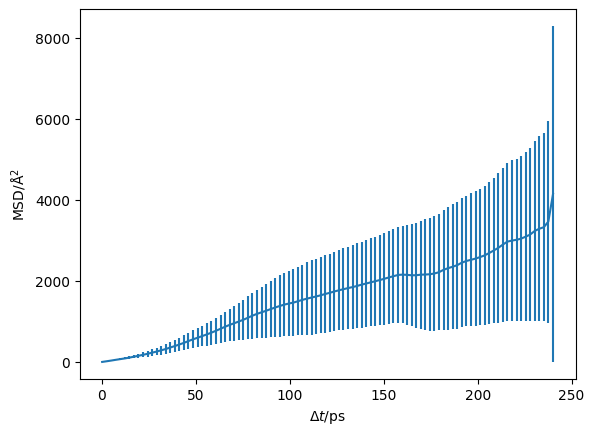

In [5]:
plt.errorbar(diff.dt, diff.msd, diff.msd_std)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.show()

In [6]:
diff.diffusion(50)

Likelihood Sampling: 100%|██████████| 1500/1500 [00:01<00:00, 1416.38it/s]


In [7]:
diff.D.n, diff.D.ci()

(0.000866656533467777, array([0.00010547, 0.00176512]))

In [8]:
diff.intercept.n, diff.intercept.ci()

(-288.4590430741514, array([-1081.22475205,   437.10835217]))

In [9]:
diff.D.samples

array([0.00078902, 0.0003271 , 0.00100542, ..., 0.00034626, 0.00105979,
       0.00107725])

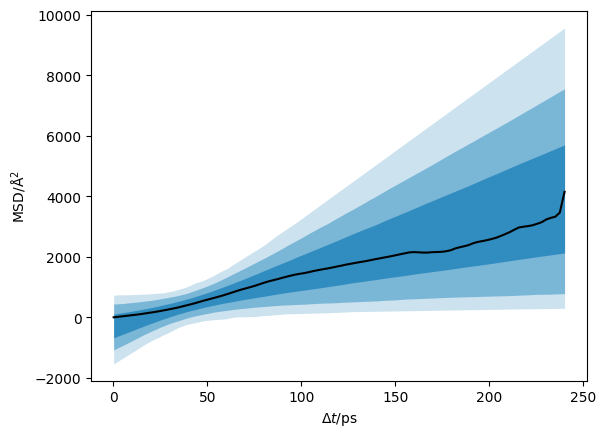

In [10]:
credible_intervals = [[16, 84], [2.5, 97.5], [0.15, 99.85]]
alpha = [0.6, 0.4, 0.2]

plt.plot(diff.dt, diff.msd, 'k-')
for i, ci in enumerate(credible_intervals):
    plt.fill_between(diff.dt,
                     *np.percentile(diff.distribution, ci, axis=1),
                     alpha=alpha[i],
                     color='#0173B2',
                     lw=0)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.show()

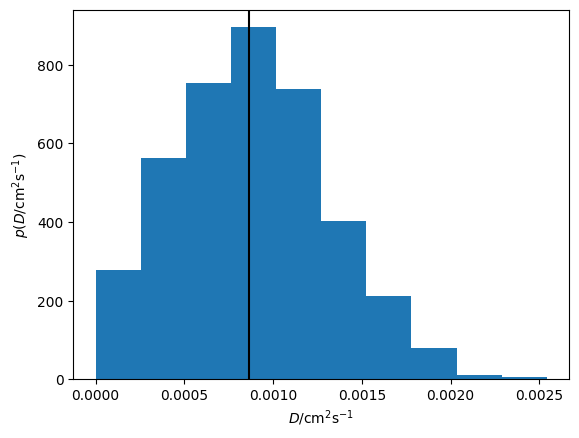

In [11]:
plt.hist(diff.D.samples, density=True)
plt.axvline(diff.D.n, c='k')
plt.xlabel('$D$/cm$^2$s$^{-1}$')
plt.ylabel('$p(D$/cm$^2$s$^{-1})$')
plt.show()